In [8]:
# Resolve paths from root project directory

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from data_tools import load_parsed_data

In [10]:
# Plot styles
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')

In [11]:

from data_tools import load_crawled_terms
crawled_terms, crawled_hashtags, crawled_phrases = load_crawled_terms("../keywords-3nov.txt", split_hashtags=True)


In [12]:
def filter_df_by_timestamp(df):
    return df[(df.timestamp > '2020-11-06 00:00:00') & (df.timestamp < '2020-11-07 00:00:00')]

# Load our tweets
cast_cols = {
    "tweet_count": "int32",
    "quote_count": "int32" 
}

for term in crawled_terms:
    cast_cols[term] = "Sparse[int8]"

tweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_tweets.json', exclude_cols={
    "cleaned_text", 
    "entities",
    "replyTo",
    "replyTo_user",
    "text", 
    "last_retweeted", 
    "place", 
    "processed",
    "media", 
    "isDeleted"
}, cast_cols=cast_cols, verbose=True, index_col="datastore_id"))
retweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_retweets.json'))

Loading 2696807 json lines
(4%): 100000 lines in ../data/14-nov/parsed_tweets.json processed (3.096437931060791 sec)
(7%): 200000 lines in ../data/14-nov/parsed_tweets.json processed (5.0122151374816895 sec)
(11%): 300000 lines in ../data/14-nov/parsed_tweets.json processed (5.693681240081787 sec)
(15%): 400000 lines in ../data/14-nov/parsed_tweets.json processed (3.537199020385742 sec)
(19%): 500000 lines in ../data/14-nov/parsed_tweets.json processed (6.171290874481201 sec)
(22%): 600000 lines in ../data/14-nov/parsed_tweets.json processed (6.593040704727173 sec)
(26%): 700000 lines in ../data/14-nov/parsed_tweets.json processed (3.744008779525757 sec)
(30%): 800000 lines in ../data/14-nov/parsed_tweets.json processed (5.241566896438599 sec)
(33%): 900000 lines in ../data/14-nov/parsed_tweets.json processed (2.790395975112915 sec)
(37%): 1000000 lines in ../data/14-nov/parsed_tweets.json processed (3.0692238807678223 sec)
(41%): 1100000 lines in ../data/14-nov/parsed_tweets.json proc

In [13]:
# build lookup table for retweets
from collections import defaultdict 
retweets_by_user = defaultdict(lambda: set())

for retweet in retweet_df.itertuples():
    retweets_by_user[retweet.user].add(retweet.retweeted)

In [14]:
def is_tweet_tagged_with_hashtag(tweet, hashtag):
    for tweet_hashtag in tweet['entities']['hashtags']:
        if tweet_hashtag['text'].lower() == hashtag.lower():
            return True
    return False

def does_tweet_contain_any_term(tweet, terms):
    for term in terms:
        if term in tweet['full_text'].lower():
            return True
    return False

In [18]:
import gzip
import json
import os


hydrated_tweet_dir = '../data/coverage-test-us-pres/2020-11-06/hydrated/'

line_count = 0
tweet_count = 0
retweet_count = 0
matching_tweets = []
matching_retweets = []

for filename in os.listdir(hydrated_tweet_dir):
    if filename.endswith(".jsonl.gz"):
        print("Processing {}".format(filename))
        with gzip.open(hydrated_tweet_dir + filename) as zipfile:
            for line in zipfile:
                tweet = json.loads(line)
                is_retweet = 'retweeted_status' in tweet
                match_array = matching_retweets if is_retweet else matching_tweets 
                
                line_count += 1
                if is_retweet:
                    retweet_count += 1
                else:
                    tweet_count += 1
                
                if (line_count % 25000 == 0):
                    print("Processed {} lines ({} tweets / {} retweets)".format(line_count, tweet_count, retweet_count))
                
                for hashtag in crawled_hashtags:
                    if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
                        match_array.append(tweet)
                        break
                if (does_tweet_contain_any_term(tweet, crawled_phrases)):
                    match_array.append(tweet)
        print("Total crawled terms found: {} tweets / {} retweets".format(len(matching_tweets), len(matching_retweets)))

Processing us-presidential-tweet-id-2020-11-06-19.jsonl.gz
Processed 25000 lines (7060 tweets / 17940 retweets)
Processed 50000 lines (13656 tweets / 36344 retweets)
Processed 75000 lines (20486 tweets / 54514 retweets)
Processed 100000 lines (27259 tweets / 72741 retweets)
Processed 125000 lines (34123 tweets / 90877 retweets)
Processed 150000 lines (40848 tweets / 109152 retweets)
Processed 175000 lines (47711 tweets / 127289 retweets)
Processed 200000 lines (54436 tweets / 145564 retweets)
Total crawled terms found: 1444 tweets / 5714 retweets
Processing us-presidential-tweet-id-2020-11-06-18.jsonl.gz
Processed 225000 lines (60835 tweets / 164165 retweets)
Processed 250000 lines (67016 tweets / 182984 retweets)
Processed 275000 lines (73293 tweets / 201707 retweets)
Processed 300000 lines (79660 tweets / 220340 retweets)
Processed 325000 lines (86369 tweets / 238631 retweets)
Processed 350000 lines (92930 tweets / 257070 retweets)
Processed 375000 lines (99658 tweets / 275342 retwee

In [20]:
matching_tweets_by_term = defaultdict(lambda: set())
missing_tweets_by_term = defaultdict(lambda: set())
missing_tweets = []
missing_retweets = []

def add_tweet_to_term_stats(term_stats, tweet):
    for term in crawled_phrases:
        if term in tweet['full_text'].lower():
            term_stats[term].add(tweet['full_text'])
    for hashtag in crawled_hashtags:
        if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
            term_stats['#' + hashtag].add(tweet['full_text'])

for tweet in matching_tweets:
    if (str(tweet['id']) in tweet_df.index):
        add_tweet_to_term_stats(matching_tweets_by_term, tweet)
    else:
        missing_tweets.append(tweet)
        add_tweet_to_term_stats(missing_tweets_by_term, tweet)

for retweet in matching_retweets:
    retweeted_tweet = retweet['retweeted_status']
    user_id = str(retweet['user']['id'])
    if (str(retweeted_tweet['id']) in retweets_by_user[user_id]):
        add_tweet_to_term_stats(matching_tweets_by_term, retweet)
    else:
        add_tweet_to_term_stats(missing_tweets_by_term, retweet)
        missing_retweets.append(retweet)

In [22]:
def print_missing_stats(matching, missing, stats_type):
    print("Missing {}/{} {} ({:,.1f}%)".format(
        len(missing),
        len(matching),
        stats_type,
        (len(missing) / len(matching)) * 100
    ))
    
    for (term, missing_tweet_set) in sorted(missing_tweets_by_term.items(), key=lambda x: -len(x[1])):
        if (len(missing_tweet_set) > 0):
            total = (len(missing_tweet_set) + len(matching_tweets_by_term[term]))
            print("Missed {:,.1f}% for term: '{}' ({}/{})".format(
                (len(missing_tweet_set) / total) * 100,
                term,
                len(missing_tweet_set),
                total
            ))      

In [23]:
print_missing_stats(matching_tweets, missing_tweets, 'tweets')

Missing 19727/29571 tweets (66.7%)
Missed 66.3% for term: 'voter fraud' (16276/24559)
Missed 66.0% for term: '#stopthesteal' (3019/4572)
Missed 64.9% for term: '#voterfraud' (2931/4518)
Missed 65.4% for term: 'election fraud' (2655/4059)
Missed 68.2% for term: '#electionfraud' (704/1033)
Missed 65.4% for term: 'ballot harvesting' (624/954)
Missed 65.0% for term: 'ballot fraud' (546/840)
Missed 63.7% for term: 'election interference' (313/491)
Missed 75.4% for term: 'democrats cheat' (205/272)
Missed 74.5% for term: '#electioninterference' (149/200)
Missed 63.9% for term: '#ballotharvesting' (117/183)
Missed 56.4% for term: '#cheatingdemocrats' (97/172)
Missed 64.0% for term: '#voterfraudisreal' (80/125)
Missed 64.4% for term: 'stolen ballots' (58/90)
Missed 66.7% for term: 'cheating democrats' (58/87)
Missed 56.3% for term: 'election tampering' (49/87)
Missed 67.2% for term: '#ballotfraud' (39/58)
Missed 70.4% for term: '#democratvoterfraud' (19/27)
Missed 81.8% for term: '#stopvoterfr

In [24]:
print_missing_stats(matching_retweets, missing_retweets, 'retweets')

Missing 81273/114102 retweets (71.2%)
Missed 66.3% for term: 'voter fraud' (16276/24559)
Missed 66.0% for term: '#stopthesteal' (3019/4572)
Missed 64.9% for term: '#voterfraud' (2931/4518)
Missed 65.4% for term: 'election fraud' (2655/4059)
Missed 68.2% for term: '#electionfraud' (704/1033)
Missed 65.4% for term: 'ballot harvesting' (624/954)
Missed 65.0% for term: 'ballot fraud' (546/840)
Missed 63.7% for term: 'election interference' (313/491)
Missed 75.4% for term: 'democrats cheat' (205/272)
Missed 74.5% for term: '#electioninterference' (149/200)
Missed 63.9% for term: '#ballotharvesting' (117/183)
Missed 56.4% for term: '#cheatingdemocrats' (97/172)
Missed 64.0% for term: '#voterfraudisreal' (80/125)
Missed 64.4% for term: 'stolen ballots' (58/90)
Missed 66.7% for term: 'cheating democrats' (58/87)
Missed 56.3% for term: 'election tampering' (49/87)
Missed 67.2% for term: '#ballotfraud' (39/58)
Missed 70.4% for term: '#democratvoterfraud' (19/27)
Missed 81.8% for term: '#stopvote

### Random sample of missing tweets/retweets



In [25]:
import numpy as np

print("-- Missing tweets --")
for tweet in np.random.choice(missing_tweets, 5):
    print("[{}]: {}".format(tweet['id'], tweet['full_text']))
    print()

print()

print("-- Missing retweets --")
for retweet in np.random.choice(missing_retweets, 5):
    print("[{}]: {}".format(retweet['id'], retweet['full_text']))
    print()

-- Missing tweets --
[1324735061275549698]: How's this possible..? These firsts, person of color, women headed to US. House, #Hispanics #Black support up, which means #Trump has coattails, THEN the coattails snipped off (he doesn't benefit from his own coattails?) Like 2020, things are upside down.. 😂😂 #ElectionFraud https://t.co/sNmf0DzsES

[1324530664679579651]: @AOC Voter Fraud!   Democrats are the Enemy of the People!

[1324568409359618048]: @TheKevinWoodman @dirtyTcats Ha! Says the man that alleges massive voter fraud in ONLY the states that Donnie lost. How convenient!

Listen to yourself. Honestly. Are you a rational adult or a gullible child?

[1324763423192817665]: #StopTheSteal https://t.co/lpmNbR59dz

[1324616446639546369]: @TeamTrump If you or someone you know has witnessed Voter Fraud please contact - The Trump Campaign. Voter Hotline, 888-630-1776, for people to report suspicious activity. Now is the time!! Do not wait!!! PLEASE RETWEET


-- Missing retweets --
[132457211

In [30]:
def filter_by_term(df, term):
    m = df.apply(lambda x: term in x['full_text'].lower(), axis=1)
    return df[m]

# Create a dataframe from matched tweets/retweets
matching_tweet_df = pd.DataFrame(matching_tweets, columns=['full_text', 'created_at']).rename(columns={
    "created_at": "timestamp"
})

matching_retweet_df = pd.DataFrame(matching_tweets, columns=['full_text','created_at']).rename(columns={
    "created_at": "timestamp"
})


In [33]:
def group_df_by_hour(df, column='timestamp'):
    grouped_by_hour = (pd.to_datetime(df[column])
        .dt.floor('H')
        .value_counts()
        .rename_axis('date')
        .reset_index(name='count')).sort_values(by=['date'])
    return grouped_by_hour.set_index('date')

def plot_hourly_coverage(our_df, matching_df, title):
    our_df_by_hour = group_df_by_hour(our_df)
    matching_df_by_hour = group_df_by_hour(matching_df)

    fig, ax = plt.subplots()

    ax.plot(
        our_df_by_hour["count"], label="Our dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.plot(
        matching_df_by_hour["count"], label="Their dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))

    ax.set_title("Coverage for '{}' (total={:,}/{:,})".format(title, len(our_df.index), len(matching_df.index)))

    return fig

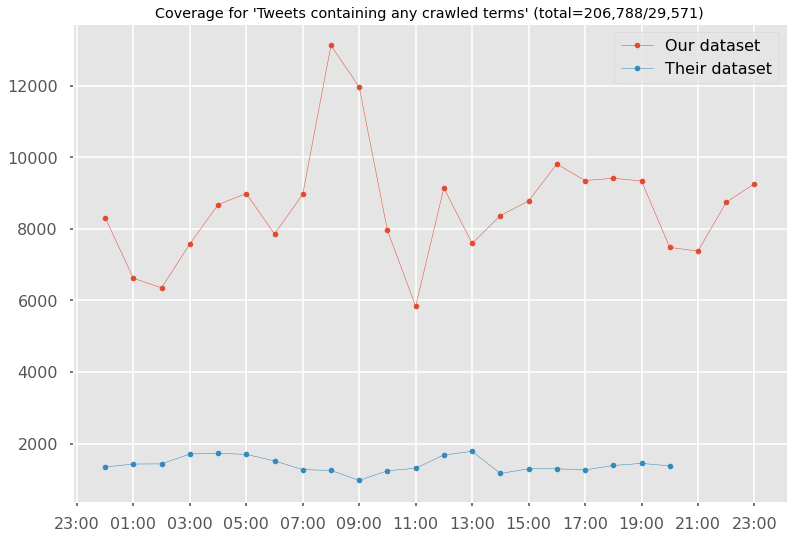

In [35]:
plot_hourly_coverage(tweet_df, matching_tweet_df, "Tweets containing any crawled terms")
None

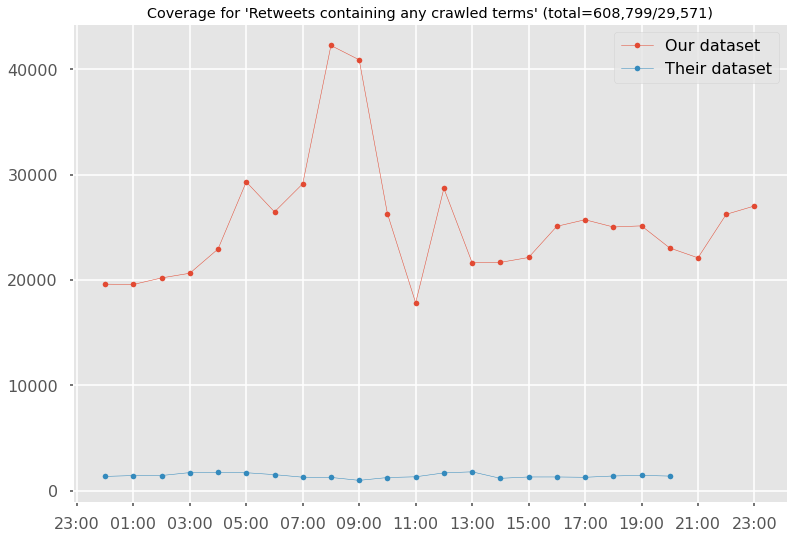

In [36]:
plot_hourly_coverage(retweet_df, matching_retweet_df, "Retweets containing any crawled terms")
None

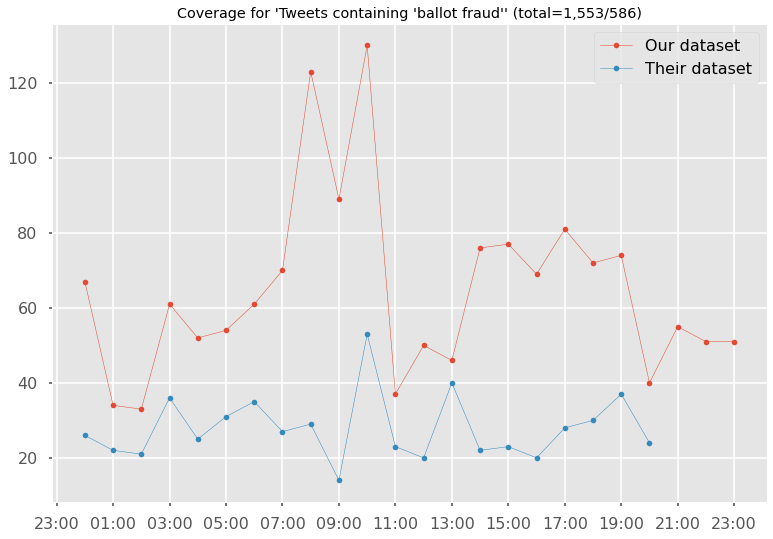

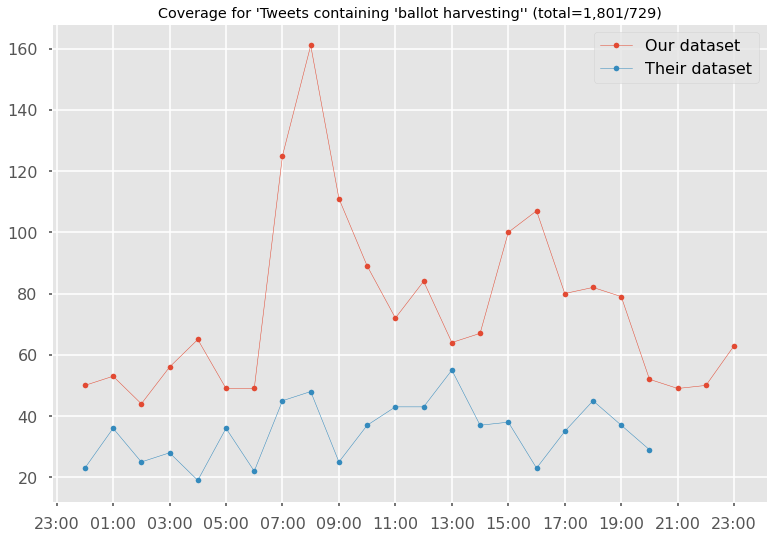

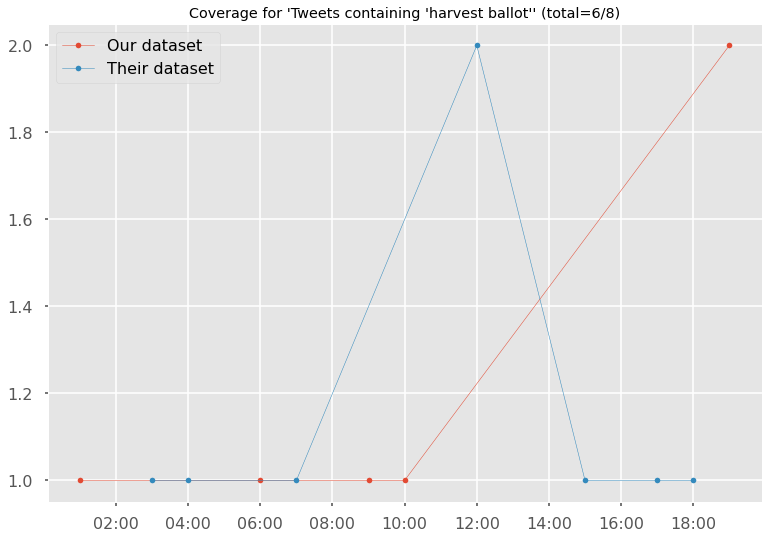

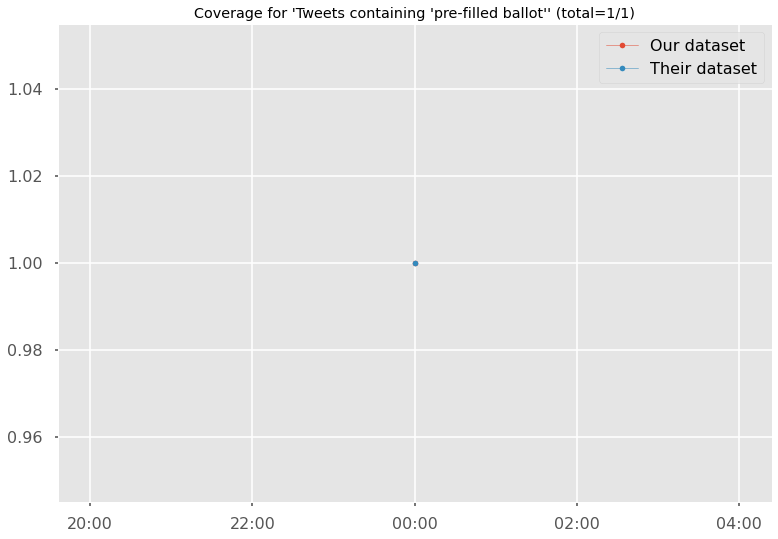

In [40]:
overlapping_terms = ["ballot fraud", "ballot harvesting", "harvest ballot", "pre-filled ballot"]

for term in overlapping_terms:
    plot_hourly_coverage(tweet_df[tweet_df[term] == 1], filter_by_term(matching_tweet_df, term), "Tweets containing '{}'".format(term))
